In [10]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.python.framework import ops
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import hickle as hkl
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import urllib
import os
import tarfile
import skimage
from tensorflow.keras import layers
import skimage.io
import skimage.transform
from flip_gradient import flip_gradient
from utils import *
from models import *


LOADING MNIST
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data\t10k-images-idx3-ubyte.gz
Extracting data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
LOADING MNIST-M
GENERATING DOMAIN DATA


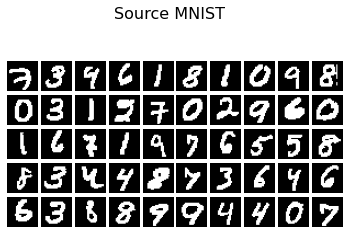

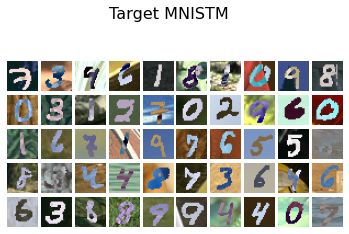

In [12]:

#Loading Mnist Data
print ("LOADING MNIST")
mnist        = input_data.read_data_sets('data', one_hot=True)
mnist_train  = (mnist.train.images > 0).reshape(55000, 28, 28, 1).astype(np.uint8) * 255
mnist_train  = np.concatenate([mnist_train, mnist_train, mnist_train], 3)
mnist_test   = (mnist.test.images > 0).reshape(10000, 28, 28, 1).astype(np.uint8) * 255
mnist_test   = np.concatenate([mnist_test, mnist_test, mnist_test], 3)
mnist_train_label = mnist.train.labels
mnist_test_label = mnist.test.labels

#Loading MnistM Data
print ("LOADING MNIST-M")
mnistm_name  = 'data//mnistm_data.hkl'
mnistm       = hkl.load(open(mnistm_name))
mnistm_train = mnistm['train']
mnistm_test  = mnistm['test']
#mnistm_valid = mnistm['valid']
mnistm_train_label = mnist_train_label
mnistm_test_label = mnist_test_label
print ("GENERATING DOMAIN DATA")

# GET PIXEL MEAN
pixel_mean = np.vstack([mnist_train, mnistm_train]).mean((0, 1, 2))
#%%
# PLOT IMAGES
imshow_grid(mnist_train, shape=[5, 10],title='Source MNIST')
imshow_grid(mnistm_train, shape=[5, 10],title='Target MNISTM')

# Create a mixed dataset for TSNE visualization
num_test = 500
combined_test_imgs = np.vstack([mnist_test[:num_test], mnistm_test[:num_test]])
combined_test_labels = np.vstack([mnist.test.labels[:num_test], mnist.test.labels[:num_test]])
combined_test_domain = np.vstack([np.tile([1., 0.], [num_test, 1]),np.tile([0., 1.], [num_test, 1])])

In [ ]:

class DSNModel(object):
    """ Domain separation model."""
    def __init__(self):
        self._build_model()
    
    def _build_model(self):
        #define the place holders
        self.source = tf.placeholder(tf.uint8, [None, 28, 28, 3],name='input_s')
        self.target = tf.placeholder(tf.uint8, [None, 28, 28, 3],name='input_t')
        
        self.y_s = tf.placeholder(tf.float32, [None, 10],name='labels_s')
        self.y_t = tf.placeholder(tf.float32, [None, 10],name='labels_t')
        
        self.d  = tf.placeholder(tf.float32, [None, 2]) # DOMAIN LABEL
        self.dw = tf.placeholder(tf.float32, [])
        
        self.X_input_s = (tf.cast(self.source, tf.float32) - pixel_mean) / 255.
        self.X_input_t= (tf.cast(self.target, tf.float32) - pixel_mean) / 255.
        
        
       
        
        # source shared encoder
        with tf.variable_scope('shared_encoder')as shared:
            self.shared_s = shared_encoder(self.X_input_s, name='shared_encoder')
                
        #target common encoder       
        with tf.variable_scope(shared,reuse=True):
            self.shared_t = shared_encoder(self.X_input_t, name='shared_encoder',reuse=True)
        
        #target private encoder       
        with tf.variable_scope('priviate_target_encoder'):
        
            self.private_t = private_target_encoder(self.X_input_t, name='target_private')
            
          #source private encoder       
        with tf.variable_scope('priviate_source_encoder'):
        
            self.private_s = private_source_encoder(self.X_input_s, name='source_private')
                
       #lables predictor     
        with tf.variable_scope('label_predictor') as pred:
            logits_s = slim.fully_connected(self.shared_s, 100,scope='fc1')
            self.logits_s = slim.fully_connected(logits_s, 10, activation_fn = None, scope='out')
        
        
        with tf.variable_scope(pred,reuse=True):
            logits_t = slim.fully_connected(self.shared_t, 100,scope='fc1')
            self.logits_t = slim.fully_connected(logits_t, 10, activation_fn = None, scope='out')
            
        #domain predictor  
        
        self.shared_feat=layers.concatenate([self.shared_s,self.shared_t],name='merged_features',axis=0)
        with tf.variable_scope('domain_predictor'):
            logits_d = flip_gradient(self.shared_feat, 0.5) # GRADIENT REVERSAL
            logits_d = slim.fully_connected(logits_d, 100,scope='d1')
            self.logits_d = slim.fully_connected(logits_d, 2, activation_fn = None, scope='out')
        
        
        #Shared decoder
        #input for decoder
        self.target_concat_feat=concat_operation(self.shared_t,self.private_t)
        self.source_concat_feat =concat_operation(self.shared_s,self.private_s)
    
        with tf.variable_scope('shared_decoder') as decoder:
             
                self.decode_s = shared_decoder(self.source_concat_feat,28,28,3)
                    
                    
        with tf.variable_scope(decoder,reuse=True):
    
            self.decode_t = shared_decoder(self.target_concat_feat,28,28,3)
                    
                

In [11]:
# Build the model graph
tf.reset_default_graph()
graph = tf.get_default_graph()
with graph.as_default():
    model = DSNModel()
    #lr = tf.placeholder(tf.float32, []) #learning rate
    
    #classification loss
    source_class_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model.logits_s , labels=model.y_s))
    

    #similarity loss
    similarity_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model.logits_d, labels=model.d))

    #difference loss
    target_diff_loss = difference_loss(model.shared_t,model.private_t,0.05)
    source_diff_loss = difference_loss(model.shared_s,model.private_s,0.05)
    diff_loss=target_diff_loss+source_diff_loss
    #reconstruction loss
    target_recon_loss = tf.contrib.losses.mean_pairwise_squared_error(model.X_input_t,model.decode_t)*1e-3#tf.contrib.losses.mean_pairwise_squared_error(target,target_recon,1e-6)
    source_recon_loss = tf.contrib.losses.mean_pairwise_squared_error(model.X_input_s,model.decode_s)*1e-3#tf.contrib.losses.mean_pairwise_squared_error(source,source_recon,1e-6)# 
    recon_loss=target_recon_loss+source_recon_loss

    #total loss
    total_loss = source_class_loss+similarity_loss+recon_loss+diff_loss
    #optimization 
    optm_class_dann  = tf.train.AdamOptimizer(0.005).minimize(total_loss)
    
    # Evaluation
   
    #source accuracy
    source_pred=tf.nn.softmax(model.logits_s)
    correct_source_pred = tf.equal(tf.argmax(source_pred, 1), tf.argmax(model.y_s, 1))
    source_acc = tf.reduce_mean(tf.cast(correct_source_pred, tf.float32))

    #target accuracy
    target_pred=tf.nn.softmax(model.logits_t)
    correct_target_pred = tf.equal(tf.argmax(target_pred, 1), tf.argmax(model.y_t, 1))
    target_acc = tf.reduce_mean(tf.cast(correct_target_pred, tf.float32))

    #domain accuracy
    domain_pred=tf.nn.softmax(model.logits_d)
    correct_domain_pred = tf.equal(tf.argmax(domain_pred, 1), tf.argmax(model.d, 1))
    accr_domain_dann = tf.reduce_mean(tf.cast(correct_domain_pred, tf.float32))
    print ("MODEL BUILT SUCCESSFULLY!!!")

MODEL BUILT SUCCESSFULLY!!!


In [12]:
def train_and_evaluate(training_mode, graph, model,batch_size=128,every_epoch=1, num_epochs=30, verbose=True):
    """Helper to run the model with different training modes."""
    
    sess=tf.Session() 
    sess.run(tf.global_variables_initializer())
   

    # Batch generators
    # Batch generators
    gen_source_batch = batch_generator(
        [mnist_train, mnist.train.labels], batch_size // 2)
    gen_target_batch = batch_generator(
        [mnistm_train, mnist.train.labels], batch_size // 2)

    domain_labels = np.vstack([np.tile([1., 0.], [batch_size // 2, 1]),
                               np.tile([0., 1.], [batch_size // 2, 1])])
    ntrain=mnist_train.shape[0]
    num_batch = int(ntrain/ batch_size)
    # Training loop
    num_steps=num_epochs*num_batch
    for i in range(num_steps):
        
        p = float(i) / num_steps
        l = 2. / (1. + np.exp(-10. * p)) - 1
        lr = 0.01 / (1. + 10 * p)**0.75

        # Training step
        if training_mode == 'DSN':
            
            batch_source, batch_y_s = next(gen_source_batch)
            batch_target, batch_y_t = next(gen_target_batch)

            feeds_class = {model.source: batch_source, model.target:batch_target, 
                           model.y_s: batch_y_s,model.d:domain_labels, model.dw: l}

            _, domain_acc,recon_l,source_loss,diff = sess.run([optm_class_dann, accr_domain_dann,recon_loss,source_class_loss,diff_loss], feed_dict=feeds_class)
            if verbose and i % 500 == 0:
                # CHECK BOTH LOSSES
                print("[%d/%d] p: %.3f d_acc: %.3f, class_loss: %.3f, recon_loss: %.3f, diff_loss: %.3f"
                      % ( i, num_steps, p, domain_acc,source_loss,recon_l,diff))
                # CHECK ACCUARACIES OF BOTH SOURCE AND TARGET
                feed_source = {model.source: mnist_test, model.y_s: mnist_test_label}
                feed_target = {model.target: mnistm_test, model.y_t: mnistm_test_label}
                accr_source_dann = sess.run(source_acc, feed_dict=feed_source)
                accr_target_dann = sess.run(target_acc, feed_dict=feed_target)
                print(" DANN: SOURCE ACCURACY: %.3f TARGET ACCURACY: %.3f"% (accr_source_dann, accr_target_dann))
            

    #shared features embeddings
    test_emb = sess.run(model.shared_feat, feed_dict={model.source: mnist_test[:num_test],model.target: mnistm_test[:num_test]})
   
   
    return test_emb,sess

In [13]:
print('\n Adaptation training')
dsn_emb,sess = train_and_evaluate('DSN', graph, model)


 Adaptation training
[0/12870] p: 0.000 d_acc: 0.500, class_loss: 2.617, recon_loss: 0.278, diff_loss: 0.002
 DANN: SOURCE ACCURACY: 0.508 TARGET ACCURACY: 0.216
[500/12870] p: 0.039 d_acc: 0.625, class_loss: 0.127, recon_loss: 0.007, diff_loss: 0.001
 DANN: SOURCE ACCURACY: 0.977 TARGET ACCURACY: 0.628
[1000/12870] p: 0.078 d_acc: 0.719, class_loss: 0.018, recon_loss: 0.005, diff_loss: 0.001
 DANN: SOURCE ACCURACY: 0.979 TARGET ACCURACY: 0.707
[1500/12870] p: 0.117 d_acc: 0.680, class_loss: 0.122, recon_loss: 0.005, diff_loss: 0.001
 DANN: SOURCE ACCURACY: 0.978 TARGET ACCURACY: 0.677
[2000/12870] p: 0.155 d_acc: 0.578, class_loss: 0.059, recon_loss: 0.005, diff_loss: 0.001
 DANN: SOURCE ACCURACY: 0.983 TARGET ACCURACY: 0.729
[2500/12870] p: 0.194 d_acc: 0.625, class_loss: 0.230, recon_loss: 0.004, diff_loss: 0.001
 DANN: SOURCE ACCURACY: 0.978 TARGET ACCURACY: 0.746
[3000/12870] p: 0.233 d_acc: 0.602, class_loss: 0.194, recon_loss: 0.004, diff_loss: 0.001
 DANN: SOURCE ACCURACY: 0.9

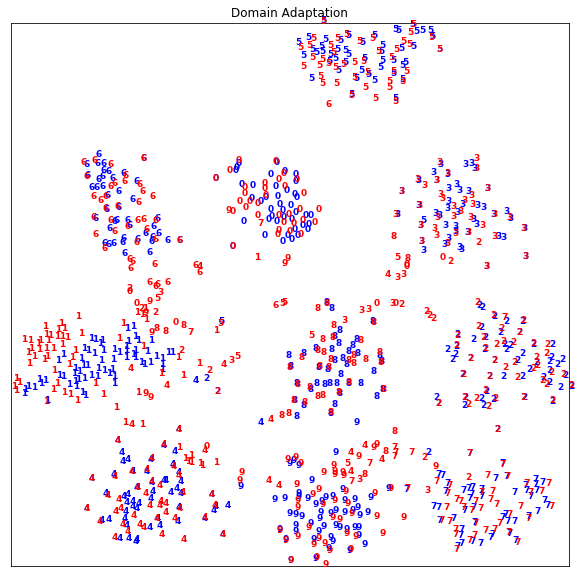

In [43]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
dsn_tsne = tsne.fit_transform(dsn_emb)


plot_embedding(dsn_tsne, combined_test_labels.argmax(1), combined_test_domain.argmax(1), 'Domain Adaptation')

In [91]:
def compare_recon(sess,batch_source,batch_target,model):
    s=sess.run([model.decode_s],feed_dict={model.source:batch_source,model.target:batch_target})
    reconstructed=[(i-i.min())/(i.max()-i.min()) for i in s[0]]
    #plt.title('Training Source Images')
    imshow_grid(batch_source, shape=[8, 8],title='Training Source Images')
   # plt.title('Reconstructed Source Images')
    imshow_grid(reconstructed,cmap='gray',shape=[8,8],title='Reconstructed Source Images')
   
    
    s=sess.run([model.decode_t],feed_dict={model.source:batch_source,model.target:batch_target})
    #reconstructed=(s[0]-s[0].min())/(s[0].max()-s[0].min())
    reconstructed=[(i-i.min())/(i.max()-i.min()) for i in s[0]]
   # plt.title('Reconstructed Target Images')
    imshow_grid(batch_target, shape=[8, 8],title='Training Target Images')
    
    imshow_grid(reconstructed,shape=[8,8],title='Reconstructed Target Images')
    #plt.title('Training Target Images')


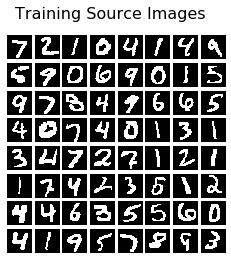

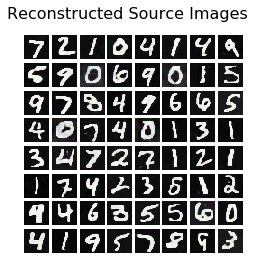

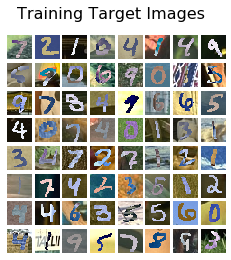

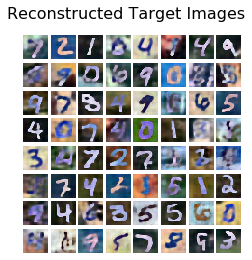

In [92]:
compare_recon(sess,mnist_test[:64],mnistm_test[:64],model)